## Visualizing Original Geoparser - Total

We have used the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) with the original language model for finding the Name Entities for the NLS collections, and select just the ones regarding with places. Later, once we have the locations entities, we have used the georesolver to resolve these locations.
                       
The query for running that we have used is the following: 

`spark-submit --driver-memory 12g --py-files defoe.zip defoe/run_query.py sparql_data_chapbooks.txt sparql defoe
.sparql.queries.geoparser_by_year config_file_chapbooks_geo.yml   -r results_test/results_chapbooks_geo_kg_word
s.yml  -n 15`


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#pio.renderers.default = "browser"
import plotly.offline as pyo
import plotly.express as px

/var/folders/4w/57rlv27n3g9b001td63pv1j00000gq/T/ipykernel_65488/3864845141.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Functions

In [2]:
def read_query_results(filename):
    with open('./results/'+filename, 'r') as f:
        query_results = yaml.load(f,Loader=yaml.Loader)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution"]
            archive = k["archive_filename"]
            title = k["title"]
            page = k["page number"]
            serie = k["serie"]
            uri = k["uri"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type({}) :
                        c_locs=[]
                        c_locs.append(locs[t]["lat"])
                        c_locs.append(locs[t]["long"])
                        c_locs.append(t.split("-")[0])
                        c_locs.append(locs[t]["snippet"])
                        c_locs.append(page)
                        c_locs.append(year)
                        c_locs.append(archive)
                        c_locs.append(title)
                        c_locs.append(uri)
                        data.append(c_locs)
                            

                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Snippet', 'Page', 'Year', 'Archive_id', 'Title', 'URI'])
                    dfs.append(df_page)
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places(place_label, place_freq, plot_type='resolved'):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.xlabel('Places', fontsize=15)
    plt.ylabel('Frequency of Places', fontsize=15)
    plt.xticks(index, place_label, rotation=80, fontsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    if plot_type == "resolved":
        plt.bar(index, place_freq, color='orange')
        plt.title('15 Places most mentioned and geo-resolved\n' )
    elif plot_type == "total": 
        plt.bar(index, place_freq, color='green')
        plt.title('15 Places most mentioned (in total) \n' )
    else :
        plt.bar(index, place_freq, color='coral')
        plt.title('15 Places most mentioned but not geo-resolved \n')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages/terms from a KG
- Identifies *entities*.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * archive_filename: Archive (Book| Edition) id 
    * georesolution: Page's geolocations after applying the georesolver
    * page_number: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * year: Publication year 
    * uri: Page uri
    

`Example:
     
   '1800':
- archive_filename: 104184353-mets.xml
  georesolution:
    Edinburgh-rb4:
      in-cc: ''
      lat: ''
      long: ''
      pop: ''
      snippet: his motlier , and into Edinburgh he goes , to a
      type: ''
  numWords: '372'
  page number: '6'
  part: None
  serie: '240'
  title: history and comical transactions of Lothian Tom, in six parts,1800
  uri: https://w3id.org/nls/i/Page/9937094823804340_104184353_6
  volume: '1'
  volumeId: '104184353'
  volumeTitle: history and comical transactions of Lothian Tom, in six parts
- archive_filename: 104184487-mets.xml
  georesolution:
    Bawn-rb9:
      in-cc: ''
      lat: ''
      long: ''
      pop: ''
      snippet: ftcaling my lair Cobleejt 1 Bawn . Then in the cold
      type: ''
    Reilly-rb6:
      in-cc: ''
      lat: ''
      long: ''
      pop: ''
      snippet: '! 3 taken was poor Reilly with his fair Cooleen Bawn'
      type: ''
    Reilly-rb7:
      in-cc: ''
      lat: ''
      long: ''
      pop: ''
      snippet: . nd taken was poor Reilly and laid in Sligo gbal
      type: ''
    Sligo-rb8:
      in-cc: ''
      lat: ''
      long: ''
      pop: ''
      snippet: poor Reilly and laid in Sligo gbal , . 11 this
      type: ''
  numWords: '287'
  page number: '5'
  part: None
  serie: '370'
  title: Four excellent new songs,1800
  uri: https://w3id.org/nls/i/Page/9937146693804340_104184487_5
  volume: '1'
  volumeId: '104184487'
  volumeTitle: Four excellent new songs`


### 1. Reading the file and creating the first dataframe

In [7]:
results=read_query_results('results_chapbooks_geo_kg_words.yml')

In [8]:
df_total= geresolution_dataframe(results)

In [9]:
df_total[df_total["Place"]=="Tary"]

Latitude Longitude Place                                           Snippet  \
0  49.3522   43.9894  Tary              of Manners , avoid unnectf Tary        
1                     Tary         is , however , necef Tary to have one , ”   
1                     Tary            how much more ; jf Tary is it to sit #   
0                     Tary  dent ; it is necd Tary that the ftyie ftiould fl   

  Page  Year          Archive_id  \
0    2  1800  104187086-mets.xml   
1    7  1801  104184858-mets.xml   
1    5  1806  104186605-mets.xml   
0    2  1815  104184853-mets.xml   

                                               Title  \
0  earnest persuasive to the serious observance o...   
1                     entertaining story-teller,1801   
1  divine shepherd: or, The good minister's care ...   
0  new letter-writer, or, Gentleman and Lady's in...   

                                                 URI  
0  https://w3id.org/nls/i/Page/9930840353804340_1...  
1  https://w3id.org/nls/i/Page/9937221103804340_1...  
1  https://w3id.org/nls/i/Page/9937663053804340_1...  
0  https://w3id.org/nls/i/Page/9937224943804340_1...

### 2. Generic Explorations 

**Important: Number of Places that has been identified!**

In [10]:
df_total[["Place"]].count()

Place    12762
dtype: int64

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [11]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'the ', '')
df_total['Place'] = df_total['Place'].str.replace(r'The ', '')

**Important: Number of Places that has been identified but not resolved!**

Creating a dataframe, df_not_resolved for futher exploration at the end of the notebook

In [12]:
df_not_resolved=df_total.loc[df_total['Latitude'] == '']
df_not_resolved.count()

Latitude      11581
Longitude     11581
Place         11581
Snippet       11581
Page          11581
Year          11581
Archive_id    11581
Title         11581
URI           11581
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [13]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude      1181
Longitude     1181
Place         1181
Snippet       1181
Page          1181
Year          1181
Archive_id    1181
Title         1181
URI           1181
dtype: int64

## 3. Exploring the places resolved (with latitude and longitude)

**Important: New dataframe- df_resolved- with just the rows has been resolved!!**

In [14]:
df_resolved = df_total[df_total['Latitude'] != '']

In [15]:
df_resolved.count()

Latitude      1181
Longitude     1181
Place         1181
Snippet       1181
Page          1181
Year          1181
Archive_id    1181
Title         1181
URI           1181
dtype: int64

Places names - forcing all to lower case, and later capitalize them

In [16]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [17]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#Displaying the first 15 rows
df_capitalized.head(15)

Latitude Longitude     Place  \
0   49.3522   43.9894      Tary   
0  49.43333   4.16667     Sault   
1        56        -4  Scotland   
0  47.91667  -3.78333   Barbary   
0  24.12638  89.86078      Arra   
1  24.12638  89.86078      Arra   
2  52.50456  39.52127      Pady   
3  52.50456  39.52127      Pady   
4  52.50456  39.52127      Pady   
5  52.50456  39.52127      Pady   
6  52.50456  39.52127      Pady   
0  35.63945   37.3736     Allas   
1   6.23438   7.46085       Ihe   
0  52.16045  -0.70312   England   
1        53        -8   Ireland   

                                             Snippet Page  Year  \
0               of Manners , avoid unnectf Tary         2  1800   
0           a wife r for one Sault , got a wife with    3  1800   
1  was the ulelulleft fair in Scotland jj kept ? ...    3  1800   
0  ress , A lady of Barbary and her huibaiid htin...   11  1800   
0              art thou ? Pady . Arra , dear ( hoy ,   19  1800   
1  foldie last , Teag . Arra , desrhoney I was three   19  1800   
2  of whvtprofcffibn art thou ? Pady . Arra , dear (   19  1800   
3         me . Tom . What Pady , was your religion '   19  1800   
4            . Tom . O then Pady how did you end the   19  1800   
5            . How old was you Pady , when you was a   19  1800   
6           . Tom . O but Pady , by your account you   19  1800   
0           It » 4ekt , dear Allas , 1 never can pay    4  1800   
1     a hall in the highlands Ihe never thoug M on :    4  1800   
0  breed Our Captain ciy 'd England and Ireland i...    4  1800   
1  Captain ciy 'd England and Ireland iny boys , v !    4  1800   

           Archive_id                                              Title  \
0  104187086-mets.xml  earnest persuasive to the serious observance o...   
0  104186550-mets.xml  Scots piper's queries: or, John Falkirk's cari...   
1  104186550-mets.xml  Scots piper's queries: or, John Falkirk's cari...   
0  104186496-mets.xml  history of the seven wise mistresses of Rome,1800   
0  104184355-mets.xml             comical sayings of Pady from Cork,1800   
1  104184355-mets.xml             comical sayings of Pady from Cork,1800   
2  104184355-mets.xml             comical sayings of Pady from Cork,1800   
3  104184355-mets.xml             comical sayings of Pady from Cork,1800   
4  104184355-mets.xml             comical sayings of Pady from Cork,1800   
5  104184355-mets.xml             comical sayings of Pady from Cork,1800   
6  104184355-mets.xml             comical sayings of Pady from Cork,1800   
0  104184489-mets.xml                     Three excellent new songs,1800   
1  104184489-mets.xml                     Three excellent new songs,1800   
0  104184487-mets.xml                      Four excellent new songs,1800   
1  104184487-mets.xml                      Four excellent new songs,1800   

                                                 URI  
0  https://w3id.org/nls/i/Page/9930840353804340_1...  
0  https://w3id.org/nls/i/Page/9937740933804340_1...  
1  https://w3id.org/nls/i/Page/9937740933804340_1...  
0  https://w3id.org/nls/i/Page/9937636163804340_1...  
0  https://w3id.org/nls/i/Page/9937095373804340_1...  
1  https://w3id.org/nls/i/Page/9937095373804340_1...  
2  https://w3id.org/nls/i/Page/9937095373804340_1...  
3  https://w3id.org/nls/i/Page/9937095373804340_1...  
4  https://w3id.org/nls/i/Page/9937095373804340_1...  
5  https://w3id.org/nls/i/Page/9937095373804340_1...  
6  https://w3id.org/nls/i/Page/9937095373804340_1...  
0  https://w3id.org/nls/i/Page/9937146803804340_1...  
1  https://w3id.org/nls/i/Page/9937146803804340_1...  
0  https://w3id.org/nls/i/Page/9937146693804340_1...  
1  https://w3id.org/nls/i/Page/9937146693804340_1...

In [18]:
df_max_geolocations= df_capitalized[['Latitude','Longitude', 'Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)  
print(df_max_geolocations.count())
#displaying just the first 15 rows
df_max_geolocations.head(15)


Place    583
count    583
dtype: int64


Place  count
471   Scotland     45
160    England     30
157  Edinburgh     24
319     London     19
251    Ireland     17
179     France     16
15         Ane     14
64   Bonaparte     14
353       Mith     13
71     Britain     13
198    Glasgow     12
447    Rob roy     11
499   Stirling     10
104      Comyn      8
334      Massa      8

In [19]:
#Getting the 15 places (and their frequencies) most mentioned
place_label= df_max_geolocations['Place'].tolist()[0:15]
place_freq= df_max_geolocations['count'].tolist()[0:15]
    

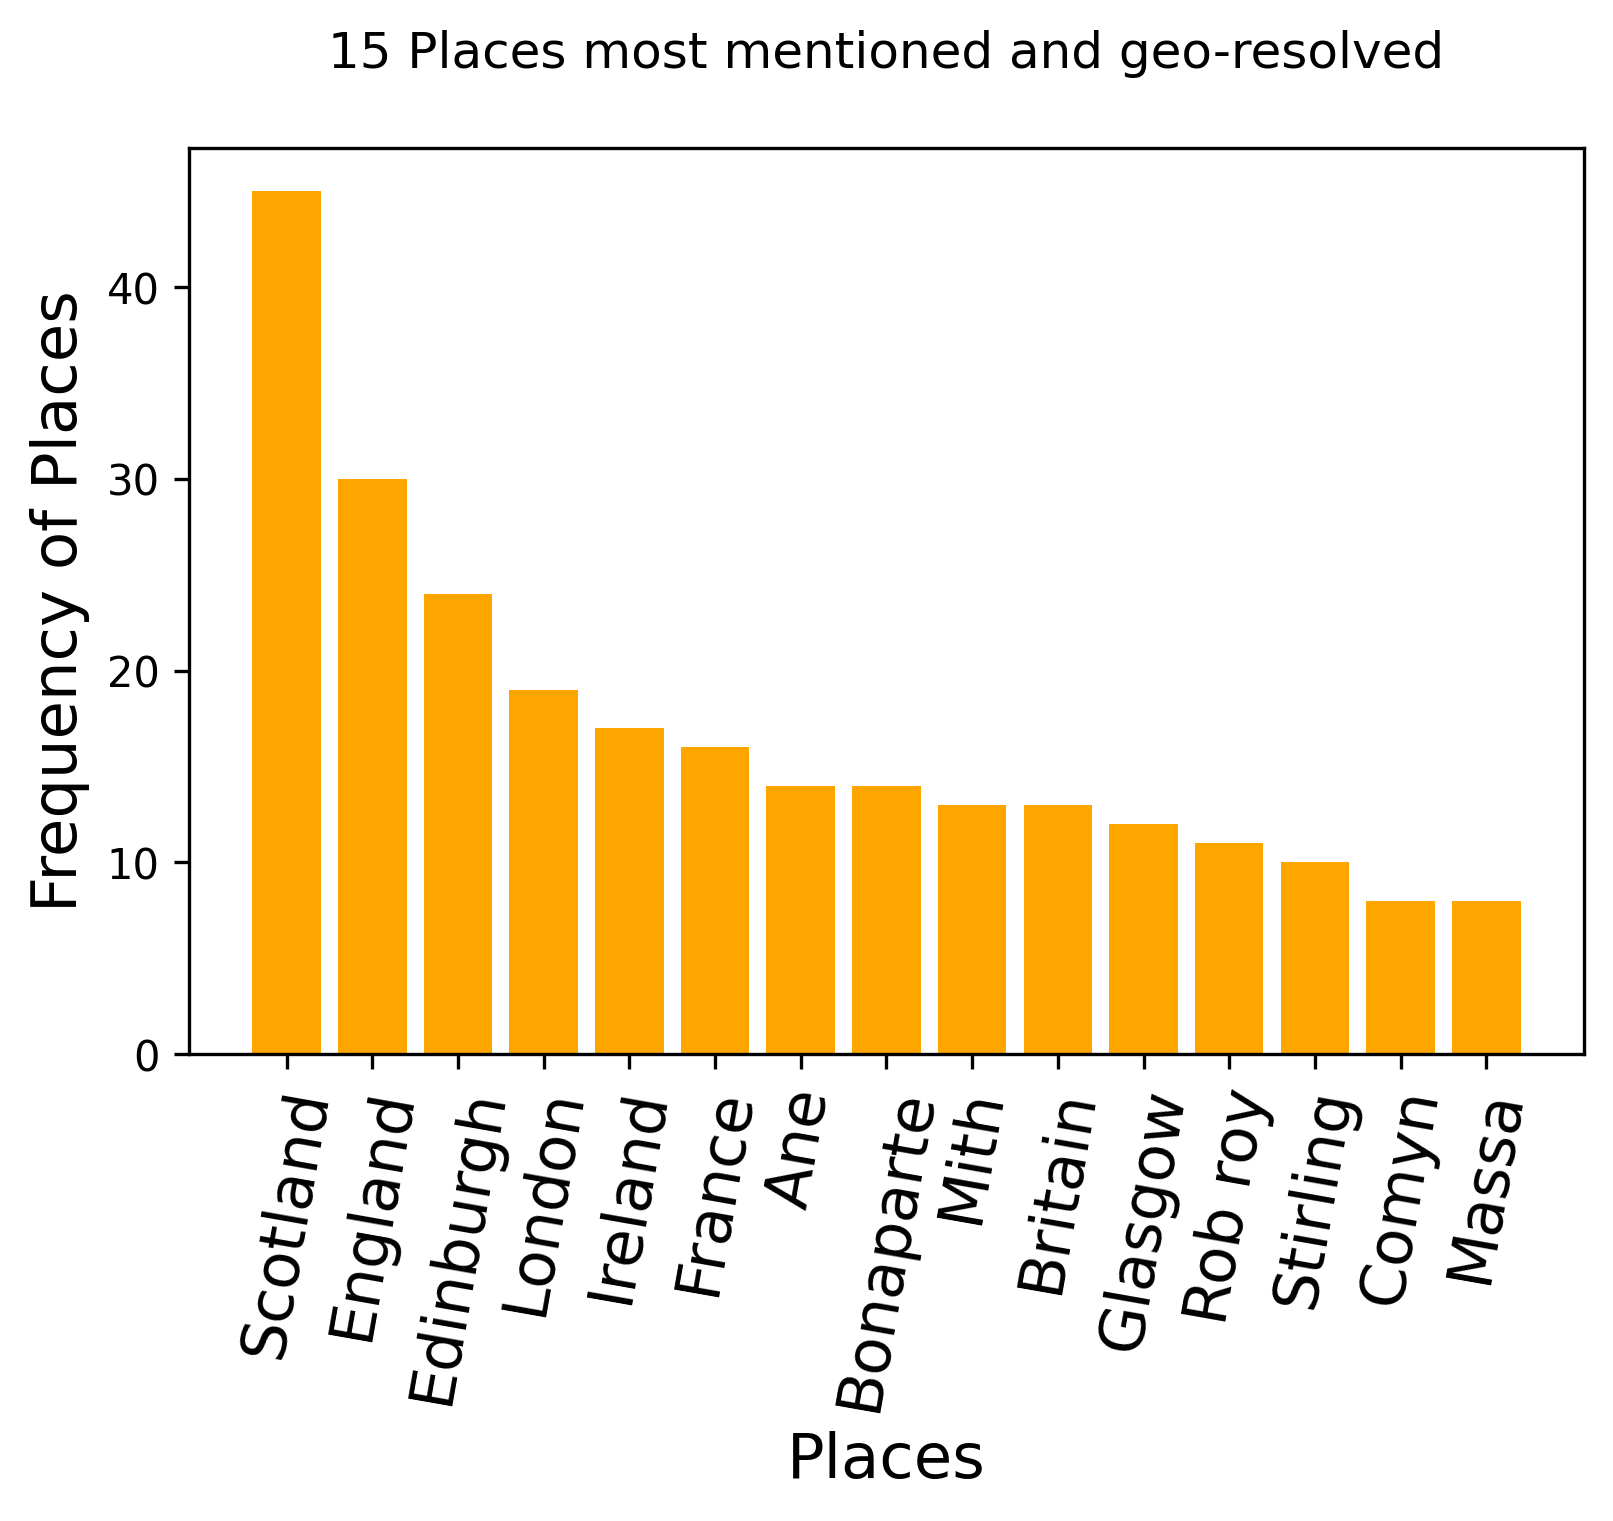

In [20]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(place_label, place_freq, plot_type='resolved')

### MAP of the Georesolve places per years

In [21]:
from IPython.display import IFrame
px.set_mapbox_access_token(open("mapbox_token").read())

In [22]:
df_map=df_capitalized.dropna(subset=['Place'])
df_map['ts'] = pd.to_datetime(df_capitalized['Year'], utc=True)
df_map=df_map.sort_values(by=['ts'], ascending=True)
df_map['Latitude'] = df_map['Latitude'].astype(float)
df_map['Longitude'] = df_map['Longitude'].astype(float)
df_map

Latitude  Longitude        Place  \
0   49.35220   43.98940         Tary   
0   41.89193   12.51133         Rome   
0   35.99403  -78.89862       Durham   
0   29.38922  104.81364         Aihe   
0   26.70117   74.53856          Rir   
..       ...        ...          ...   
1   33.88146   10.09820          Gae   
0   54.98333   -6.46667       Craigs   
1   55.85000   -3.13333  Hawthornden   
0   52.16045   -0.70312      England   
0    5.87693  -10.04964     Buchanan   

                                              Snippet Page  Year  \
0                of Manners , avoid unnectf Tary         2  1800   
0      BELIEVE th © Pope of Rome to be the right heir   21  1800   
0                I. I. ane , in Durham , Price % < S.   24  1800   
0          offer . He spoke c Aihe darts o ® my bonny    3  1800   
0                    your gate o ‘ t Rir , so l mad *   24  1800   
..                                                ...  ...   ...   
1           men o ’ dealin ’s Gae double price , gi ’   12  1880   
0   and braes sae bonnie , Craigs and water , wood...   19  1880   
1   , Save the Muses ’ Hawthornden ! * Ilka sound and   19  1880   
0     twa weeks hence , in England , there Would be a   12  1880   
0      s THE LIFE OF OEOHOE BUCHANAN . 11 marry her ,   13  1880   

            Archive_id                                              Title  \
0   104187086-mets.xml  earnest persuasive to the serious observance o...   
0   104184353-mets.xml  history and comical transactions of Lothian To...   
0   104187086-mets.xml  earnest persuasive to the serious observance o...   
0   104184496-mets.xml                Six excellent. [sic] new songs,1800   
0   104184347-mets.xml  ancient and modern history of Buck-haven in Fi...   
..                 ...                                                ...   
1   104184163-mets.xml          Watty and May, or The wife reclaimed,1880   
0   104184160-mets.xml                      history of Will and Jean,1880   
1   104184160-mets.xml                      history of Will and Jean,1880   
0   104184163-mets.xml          Watty and May, or The wife reclaimed,1880   
0   104184167-mets.xml  witty and entertaining exploits of Geo. Buchan...   

                                                  URI  \
0   https://w3id.org/nls/i/Page/9930840353804340_1...   
0   https://w3id.org/nls/i/Page/9937094823804340_1...   
0   https://w3id.org/nls/i/Page/9930840353804340_1...   
0   https://w3id.org/nls/i/Page/9937143133804340_1...   
0   https://w3id.org/nls/i/Page/9937094663804340_1...   
..                                                ...   
1   https://w3id.org/nls/i/Page/9937049273804340_1...   
0   https://w3id.org/nls/i/Page/9937048213804340_1...   
1   https://w3id.org/nls/i/Page/9937048213804340_1...   
0   https://w3id.org/nls/i/Page/9937049273804340_1...   
0   https://w3id.org/nls/i/Page/9937051843804340_1...   

                          ts  
0  1800-01-01 00:00:00+00:00  
0  1800-01-01 00:00:00+00:00  
0  1800-01-01 00:00:00+00:00  
0  1800-01-01 00:00:00+00:00  
0  1800-01-01 00:00:00+00:00  
..                       ...  
1  1880-01-01 00:00:00+00:00  
0  1880-01-01 00:00:00+00:00  
1  1880-01-01 00:00:00+00:00  
0  1880-01-01 00:00:00+00:00  
0  1880-01-01 00:00:00+00:00  

[1181 rows x 10 columns]

In [23]:
fig=px.scatter_mapbox(df_map, lat="Latitude", lon="Longitude", animation_frame="Year",
                  title="Identified Places", hover_name="Place",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=20, zoom=10)

In [24]:
fig.show()

In [25]:
df_map_count=df_map.groupby(['Latitude','Longitude', 'Year', 'Place']).count().reset_index()
df_map_count=df_map_count.rename(columns={"Archive_id": "Frequency"})
df_map_count=df_map_count.round(8)
for index, row in df_map.iterrows():
    lat=row['Latitude']
    long=row['Longitude']
    place_name=df_map[(df_map.Latitude == lat) & (df_map.Longitude == long)]['Place'].head(1).iloc[0]
    df_map_count.at[index, 'name']=place_name

df_map_count['Year'] = pd.to_datetime(df_map_count['Year'], utc=True)
df_map_count=df_map_count.sort_values(by=['Year'], ascending=True)
df_map_count["Year"]=pd.to_datetime(df_map_count['Year'], utc=True).dt.strftime('%Y')
df_map_count=df_map_count.sort_values(by=['ts'], ascending=True)
max_freq=df_map_count["Frequency"].max()

In [26]:
df_map_count

Latitude  Longitude  Year     Place  Snippet  Page  Frequency  Title  \
187  25.10602   81.81110  1800       Jor        1     1          1      1   
314  35.91667   14.43333  1839        Mt        1     1          1      1   
557  48.85341    2.34880  1839     Paris        1     1          1      1   
218  28.73970  -98.17862  1839     Peggy        1     1          1      1   
811  56.05549   -3.62609  1839   Culross        1     1          1      1   
..        ...        ...   ...       ...      ...   ...        ...    ...   
152  18.61667  -74.15000  1802      Mith        7     7          7      7   
537  47.67399 -122.12151  1840   Redmond        8     8          8      8   
252  32.07292  -98.47032  1840     Comyn        8     8          8      8   
646  52.16045   -0.70312  1840   England       11    11         11     11   
800  56.00000   -4.00000  1840  Scotland       11    11         11     11   

     URI  ts name  
187    1   1  NaN  
314    1   1  NaN  
557    1   1  NaN  
218    1   1  NaN  
811    1   1  NaN  
..   ...  ..  ...  
152    7   7  NaN  
537    8   8  NaN  
252    8   8  NaN  
646   11  11  NaN  
800   11  11  NaN  

[862 rows x 11 columns]

In [36]:
fig=px.scatter_mapbox(df_map_count, lat="Latitude", lon="Longitude", animation_frame="Year",
                  color="Frequency", size="Frequency",
                  range_color=(0,max_freq),
                  title="Performances Places Frequency", 
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=30, zoom=10, hover_name="Place")

## unc-comment this line if you want to show the map
fig.show()

## 4. Exploring the locations not resolved

Places names - forcing all to lower case, and later capitalize them

In [28]:
df4 = df_not_resolved.copy()
df4['Place']=df_not_resolved['Place'].apply(str.lower)

In [29]:
df_not_res_cap= df4.copy()
df_not_res_cap['Place']=df4['Place'].apply(str.capitalize)


In [30]:
df_not_resolved_max = df_not_res_cap[['Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

print(df_not_resolved_max.count())
#displapying the first 15 rows
df_not_resolved_max.head(15)

Place    3001
count    3001
dtype: int64


Place  count
2394   Scotland    524
833     England    311
1652     London    214
802   Edinburgh    210
916      France    172
988     Glasgow    140
1245        Ihe    115
1309    Ireland    110
2080       Pady     99
2885    Wallace     96
2252    Redmond     77
2924        Wha     76
2281    Rob roy     75
2297       Rome     73
2340        Sae     69

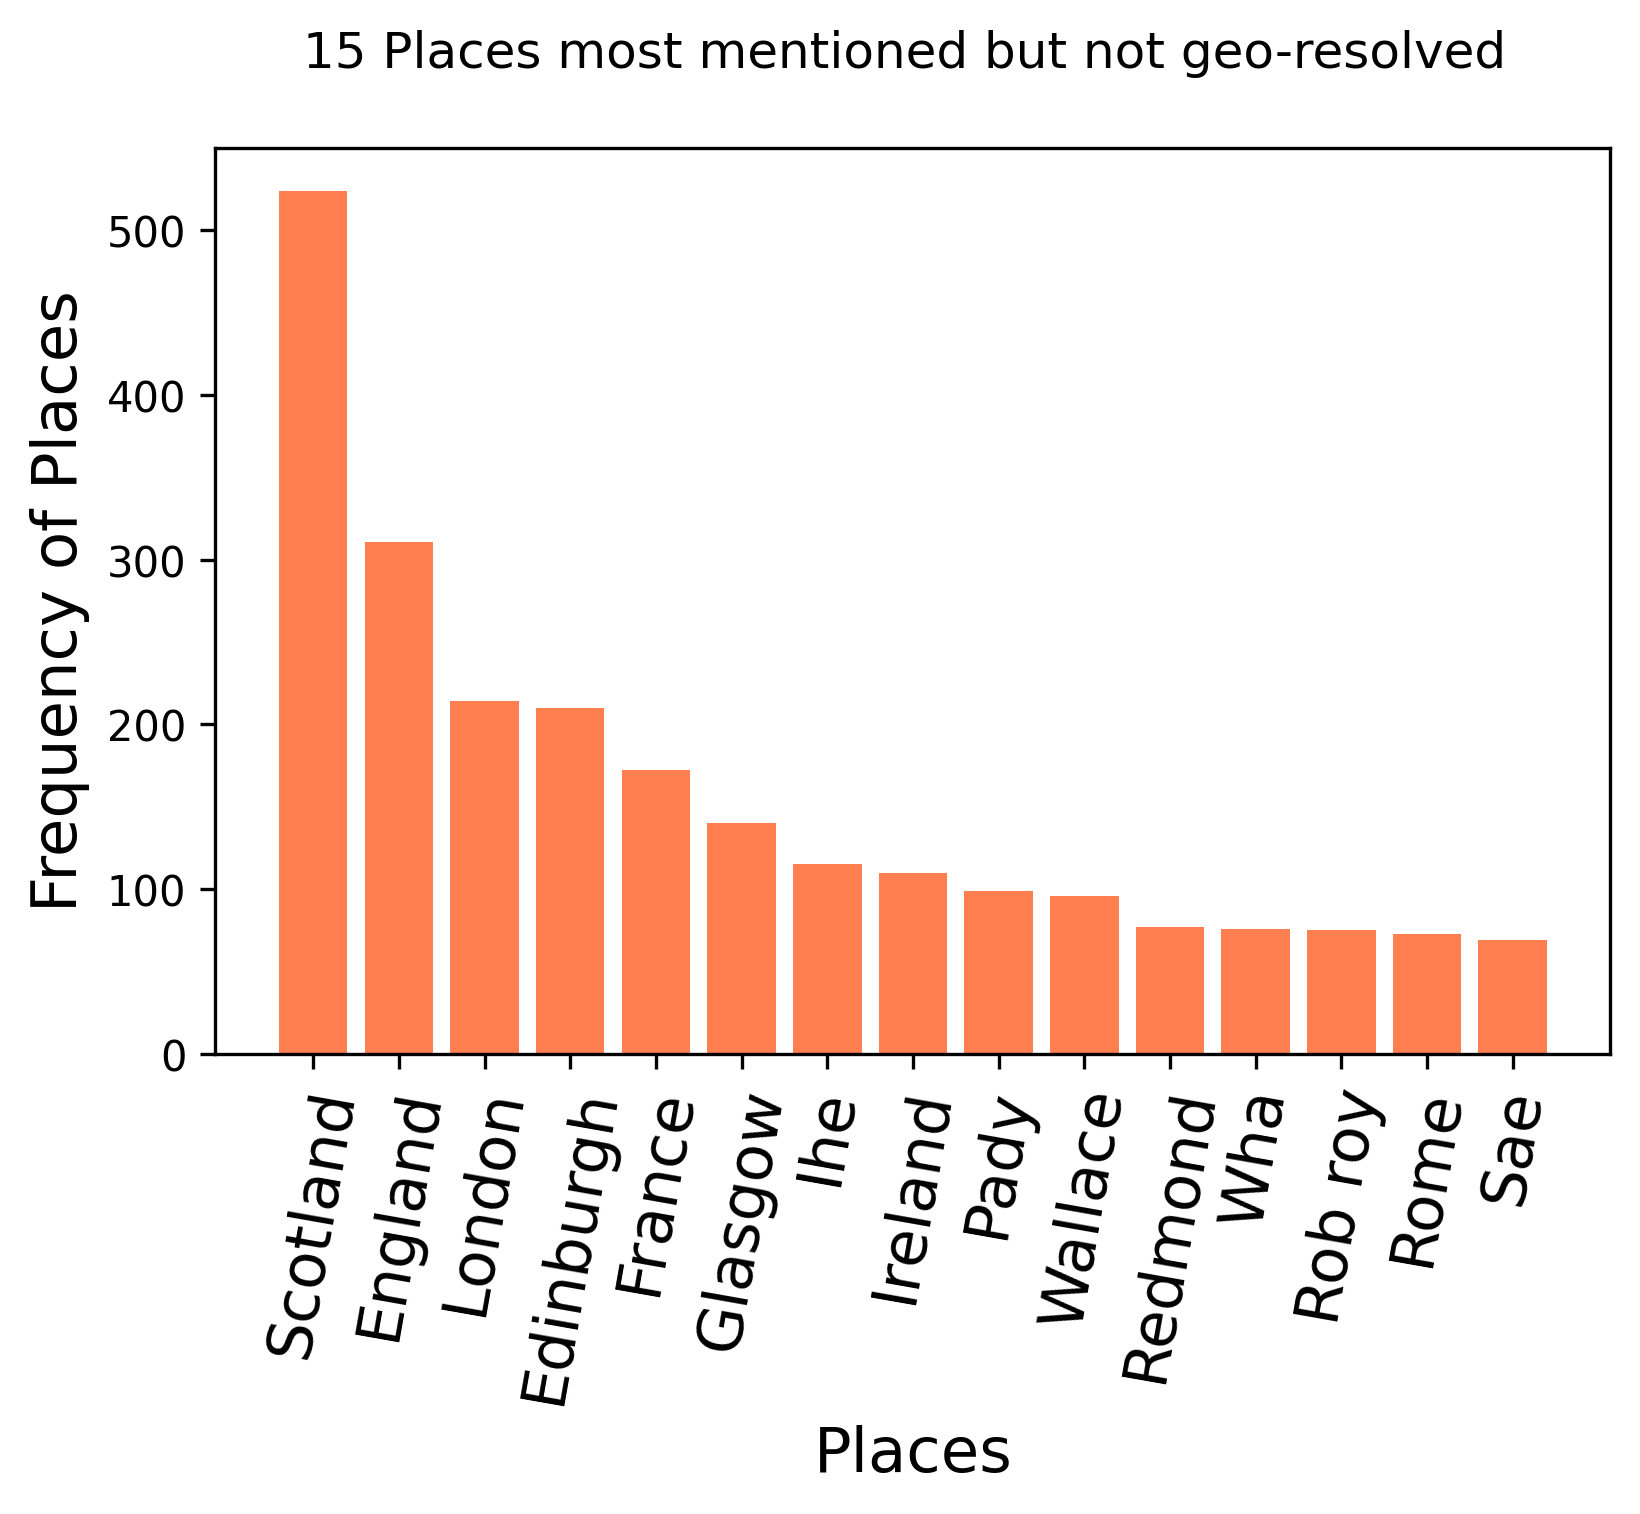

In [31]:
#Getting the 15 places (and their frequencies) most mentioned
place_label_not_resolved= df_not_resolved_max['Place'].tolist()[0:15]
place_freq_not_resolved= df_not_resolved_max['count'].tolist()[0:15]
plot_bar_places(place_label_not_resolved, place_freq_not_resolved, plot_type='not_resolved')

## 5. Exploring the locations resolved and not resolved

In [32]:
df6 = df_total.copy()
df6['Place']=df_total['Place'].apply(str.lower)

In [33]:
dft_capitalized= df6.copy()
dft_capitalized['Place']=df6['Place'].apply(str.capitalize)
#Displaying the first 15 rows
dft_capitalized.head(15)

Latitude Longitude      Place  \
0                     Edinburgh   
0                          Bawn   
1                        Reilly   
2                        Reilly   
3                         Sligo   
0                         Chism   
0                          Inna   
1                          Weil   
2                        Willie   
3                        Willie   
4                        Willie   
5                        Willie   
6                        Willie   
7                        Willie   
8                        Willie   

                                             Snippet Page  Year  \
0    his motlier , and into Edinburgh he goes , to a    6  1800   
0  ftcaling my lair Cobleejt 1 Bawn . Then in the...    5  1800   
1  ! 3 taken was poor Reilly with his fair Coolee...    5  1800   
2  . nd taken was poor Reilly and laid in Sligo gbal    5  1800   
3     poor Reilly and laid in Sligo gbal , . 11 this    5  1800   
0              X , ] THE CATE CHISM . That is to say   13  1800   
0          wife , for ye w Inna ken their Drape wi ’    3  1800   
1            a w ise Willie . Weil , mither , l will    3  1800   
2         e you the better ! Willie . Bat mither , i    3  1800   
3         t ! Muher Indeed , Willie , ye may try gin    3  1800   
4            but tak my advice , Willie an ’ ne ’ er    3  1800   
5  as a browfterwile ’s backlide Willie Well , mi...    3  1800   
6      ? Mither . Indeed , Willie , ye may try Belly    3  1800   
7          to court a w ise Willie . Weil , mither ,    3  1800   
8   , for my bleffi ig Willie , lae the kifies thick    3  1800   

           Archive_id                                              Title  \
0  104184353-mets.xml  history and comical transactions of Lothian To...   
0  104184487-mets.xml                      Four excellent new songs,1800   
1  104184487-mets.xml                      Four excellent new songs,1800   
2  104184487-mets.xml                      Four excellent new songs,1800   
3  104184487-mets.xml                      Four excellent new songs,1800   
0  104187086-mets.xml  earnest persuasive to the serious observance o...   
0  104186547-mets.xml                              art of courtship,1800   
1  104186547-mets.xml                              art of courtship,1800   
2  104186547-mets.xml                              art of courtship,1800   
3  104186547-mets.xml                              art of courtship,1800   
4  104186547-mets.xml                              art of courtship,1800   
5  104186547-mets.xml                              art of courtship,1800   
6  104186547-mets.xml                              art of courtship,1800   
7  104186547-mets.xml                              art of courtship,1800   
8  104186547-mets.xml                              art of courtship,1800   

                                                 URI  
0  https://w3id.org/nls/i/Page/9937094823804340_1...  
0  https://w3id.org/nls/i/Page/9937146693804340_1...  
1  https://w3id.org/nls/i/Page/9937146693804340_1...  
2  https://w3id.org/nls/i/Page/9937146693804340_1...  
3  https://w3id.org/nls/i/Page/9937146693804340_1...  
0  https://w3id.org/nls/i/Page/9930840353804340_1...  
0  https://w3id.org/nls/i/Page/9937740643804340_1...  
1  https://w3id.org/nls/i/Page/9937740643804340_1...  
2  https://w3id.org/nls/i/Page/9937740643804340_1...  
3  https://w3id.org/nls/i/Page/9937740643804340_1...  
4  https://w3id.org/nls/i/Page/9937740643804340_1...  
5  https://w3id.org/nls/i/Page/9937740643804340_1...  
6  https://w3id.org/nls/i/Page/9937740643804340_1...  
7  https://w3id.org/nls/i/Page/9937740643804340_1...  
8  https://w3id.org/nls/i/Page/9937740643804340_1...

In [34]:
dft_max_geolocations= dft_capitalized[['Latitude','Longitude', 'Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)  
print(dft_max_geolocations.count())
#displaying just the first 15 rows
dft_max_geolocations.head(15)

Place    3164
count    3164
dtype: int64


Place  count
2514   Scotland    569
868     England    341
836   Edinburgh    234
1728     London    233
955      France    188
1032    Glasgow    152
1368    Ireland    127
1299        Ihe    119
2178       Pady    105
3037    Wallace    100
2395    Rob roy     86
2365    Redmond     85
3080        Wha     81
2411       Rome     81
392     Britain     77

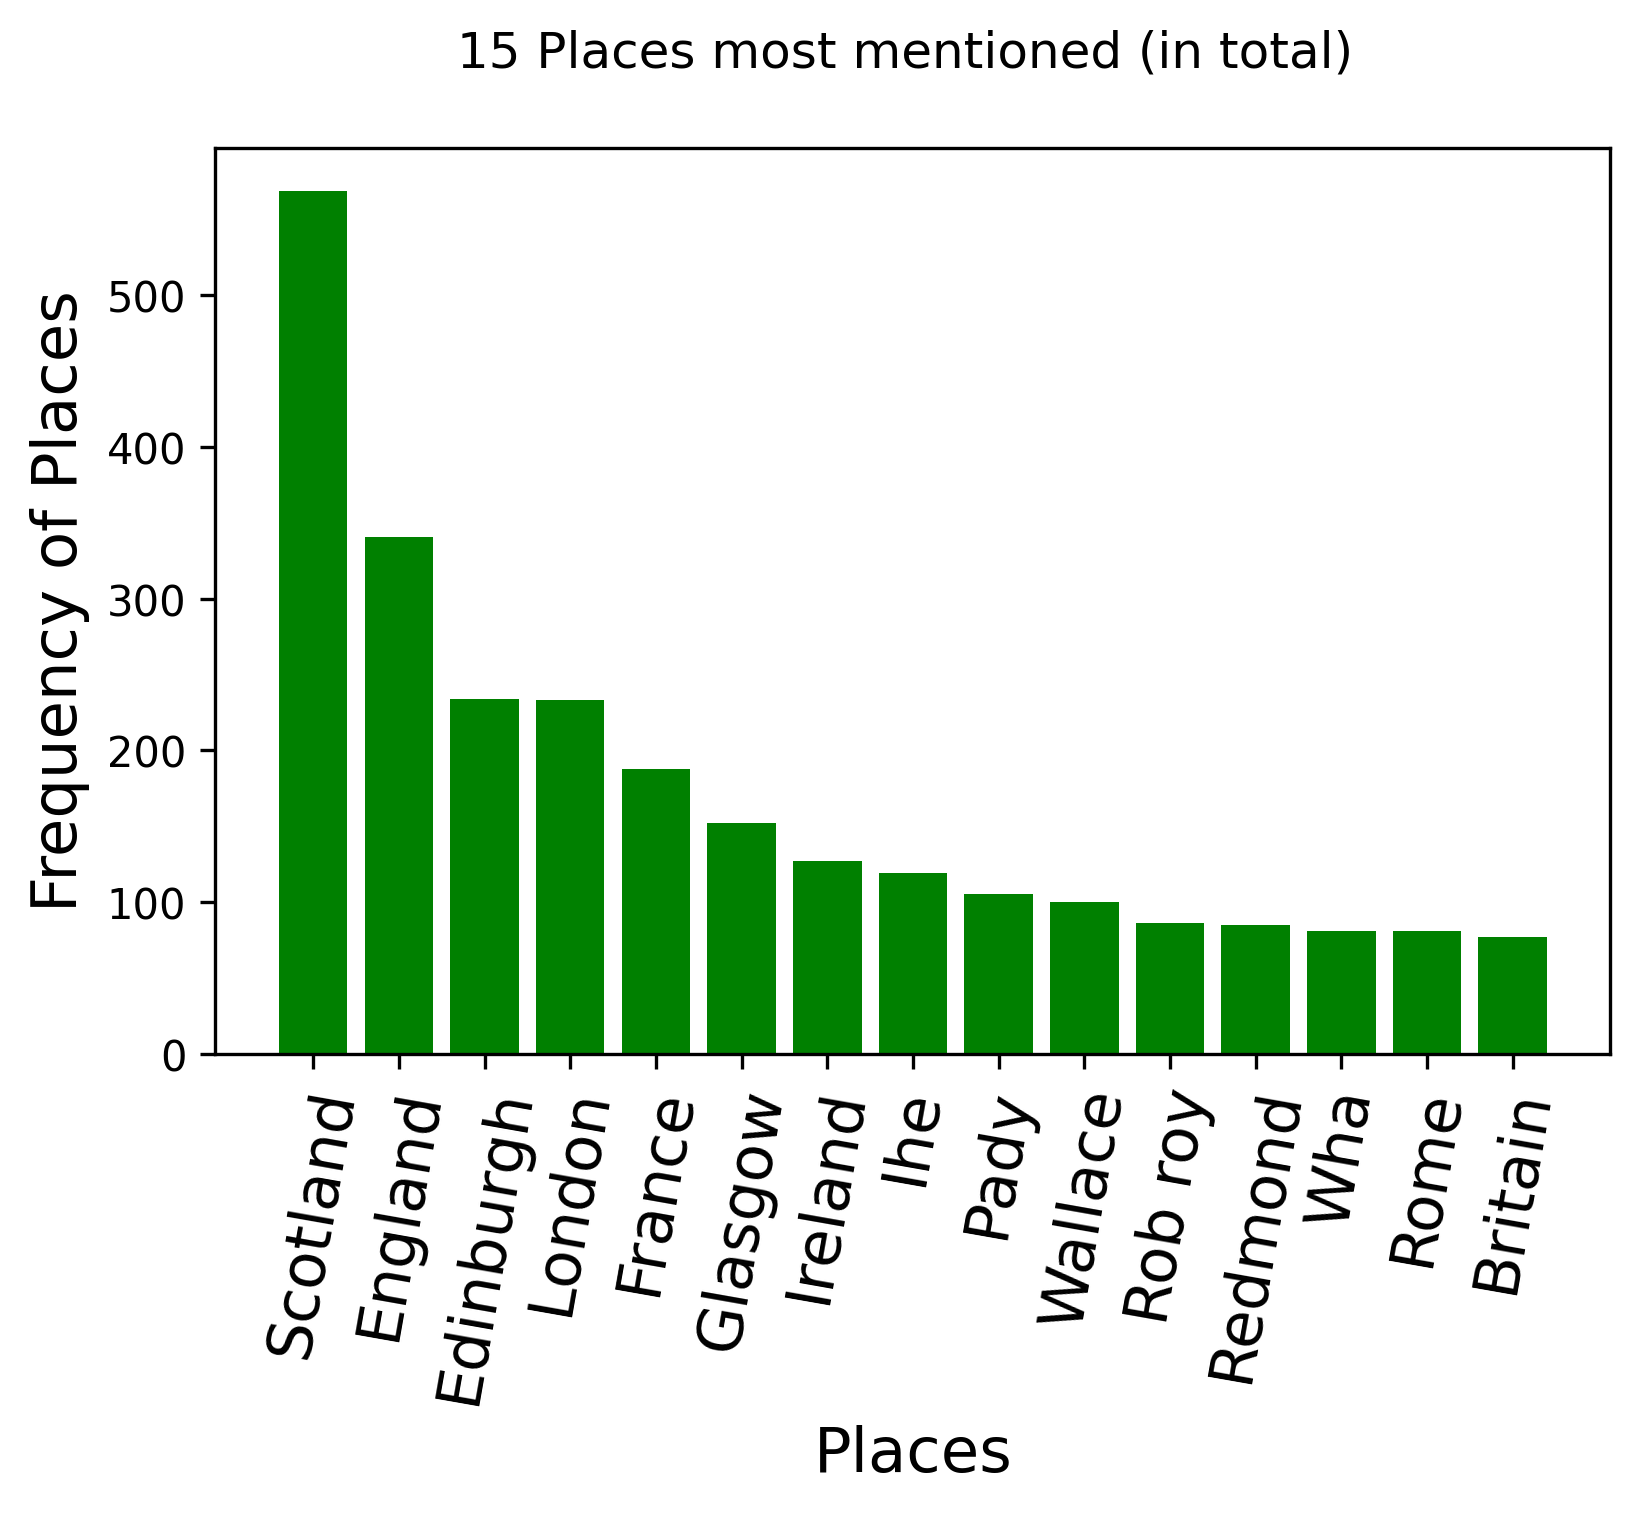

In [35]:
#Getting the 15 places (and their frequencies) most mentioned
place_label= dft_max_geolocations['Place'].tolist()[0:15]
place_freq= dft_max_geolocations['count'].tolist()[0:15]
mpl.rcParams['figure.dpi']=300
plot_bar_places(place_label, place_freq, plot_type='total')